# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy.stats import entropy
import airr
import json
import itertools
from kneed import KneeLocator
from itertools import combinations
import os
import repertoire_zoo.bird as bird
import repertoire_zoo.giraffe as giraffe

## Set Up Data Directories

In [2]:
# Specify the dataset directory
data_dir = '/mnt/md0/Projects/MonsonLab/COVVAX/vdjserver/'
repcalc_dir = data_dir + 'a9803592-eaa3-47b5-ac99-d91e8a1434fc-007/'
# Specify the directory path where you would like to save your figures
fig_dir = 'Figures/'
# Create the directory if it doesn't exist
os.makedirs(fig_dir, exist_ok=True)
print(f"Directory '{fig_dir}' is created or already exists.")


Directory 'Figures/' is created or already exists.


## Read metadata files

In [3]:
# We should read the metadata files from the repcalc directory
data = airr.read_airr(f"{repcalc_dir}repertoires.airr.json")
repertoires = { obj['repertoire_id'] : obj for obj in data['Repertoire'] }
print("Total Number of Repertoires: ", len(repertoires))

data = airr.read_airr(f"{repcalc_dir}repertoires.airr.json")
#data = airr.read_airr(f"{repcalc_dir}repertoire_groups.airr.json")
repertoire_groups = { obj['repertoire_group_id'] : obj for obj in data['RepertoireGroup'] }
print("Total Number of Repertoire Groups: ", len(repertoire_groups))

for rep_group_id in repertoire_groups:
    print(rep_group_id, repertoire_groups[rep_group_id]['repertoire_group_name'])

Total Number of Repertoires:  166
Total Number of Repertoire Groups:  6
b08f9f20-8770-42e2-a785-ff9443b6edb6 High neutralization
167ecf28-c395-40ed-9651-a7ef7d0784cb Low neutralization
ad5489b5-6cff-4773-bb76-ec09b2573ff3 Cat 1. High Neutralization
08475c9e-efb6-4302-8bb1-77186b5b86b9 Cat 1. Low Neutralization
1672807c-ba98-4ec4-aa96-e2023c4dd23a Cat. 4, 5. High Neutralization
2abdc4e5-dd79-4c39-b7b9-b4e8ee642ec1 Cat 6. Low Neutralization


## Load and plot gene usage data

In [4]:
processing_stage = 'igblast.makedb.gene.clone'
groups = [
    ('b08f9f20-8770-42e2-a785-ff9443b6edb6', 'High'),
    ('167ecf28-c395-40ed-9651-a7ef7d0784cb', 'Low'),
    # ('81569c47-6d35-4b0d-921e-6696a0777828', 'Cancer Ovary')
    # add more if needed
]
# Step 1: load and prepare data
gene_usage_df = bird.load_gene_usage_group_data(repcalc_dir, groups, processing_stage, call_type = 'v_call', level = 'subgroup')
gene_usage_df


,repertoire_group_id,level,mode,productive,gene,sequence_count,duplicate_count,sequence_frequency,duplicate_frequency,N,sequence_count_avg,sequence_count_std,sequence_frequency_avg,sequence_frequency_std,duplicate_count_avg,duplicate_count_std,duplicate_frequency_avg,duplicate_frequency_std,condition
0,b08f9f20-8770-42e2-a785-ff9443b6edb6,subgroup,proportion,True,IGHV1,260485.0,561925.0,1.233358e-01,1.234400e-01,150.0,1736.566667,2682.381839,0.118593,0.065947,3746.166667,6130.075250,0.129811,0.072771,High
1,167ecf28-c395-40ed-9651-a7ef7d0784cb,subgroup,proportion,True,IGHV1,36183.0,92559.0,1.437887e-01,1.478330e-01,16.0,2261.437500,3124.100489,0.117529,0.065777,5784.937500,7612.721865,0.126543,0.075472,Low
2,b08f9f20-8770-42e2-a785-ff9443b6edb6,subgroup,proportion,True,IGHV2,49614.0,111929.0,2.349150e-02,2.458784e-02,150.0,330.760000,657.511525,0.021699,0.025108,746.193333,1701.569022,0.023673,0.032779,High
3,167ecf28-c395-40ed-9651-a7ef7d0784cb,subgroup,proportion,True,IGHV2,6738.0,13911.0,2.677635e-02,2.221832e-02,16.0,421.125000,704.540595,0.021669,0.019545,869.437500,1420.787339,0.020391,0.018733,Low
4,b08f9f20-8770-42e2-a785-ff9443b6edb6,subgroup,proportion,True,IGHV3,1054986.0,1953153.0,4.995204e-01,4.290560e-01,150.0,7033.240000,10047.437137,0.497019,0.165073,13021.020000,19246.551074,0.469642,0.172782,High
5,167ecf28-c395-40ed-9651-a7ef7d0784cb,subgroup,proportion,True,IGHV3,114396.0,237013.0,4.546018e-01,3.785515e-01,16.0,7149.750000,11101.676627,0.425621,0.148314,14813.312500,20645.424344,0.395827,0.159293,Low
6,b08f9f20-8770-42e2-a785-ff9443b6edb6,subgroup,proportion,True,IGHV4,646060.0,1707706.0,3.058999e-01,3.751378e-01,150.0,4307.066667,6256.642760,0.316403,0.177288,11384.706667,25280.782156,0.327357,0.192713,High
7,167ecf28-c395-40ed-9651-a7ef7d0784cb,subgroup,proportion,True,IGHV4,84744.0,260902.0,3.367668e-01,4.167065e-01,16.0,5296.500000,8745.697670,0.400778,0.191511,16306.375000,30197.110967,0.424160,0.211378,Low
8,b08f9f20-8770-42e2-a785-ff9443b6edb6,subgroup,proportion,True,IGHV5,76440.0,157222.0,3.619322e-02,3.453751e-02,150.0,509.600000,804.340549,0.035690,0.036267,1048.146667,1660.696896,0.037901,0.039085,High
9,167ecf28-c395-40ed-9651-a7ef7d0784cb,subgroup,proportion,True,IGHV5,8647.0,19508.0,3.436258e-02,3.115771e-02,16.0,540.437500,823.807985,0.029538,0.024794,1219.250000,1924.306126,0.028924,0.024505,Low


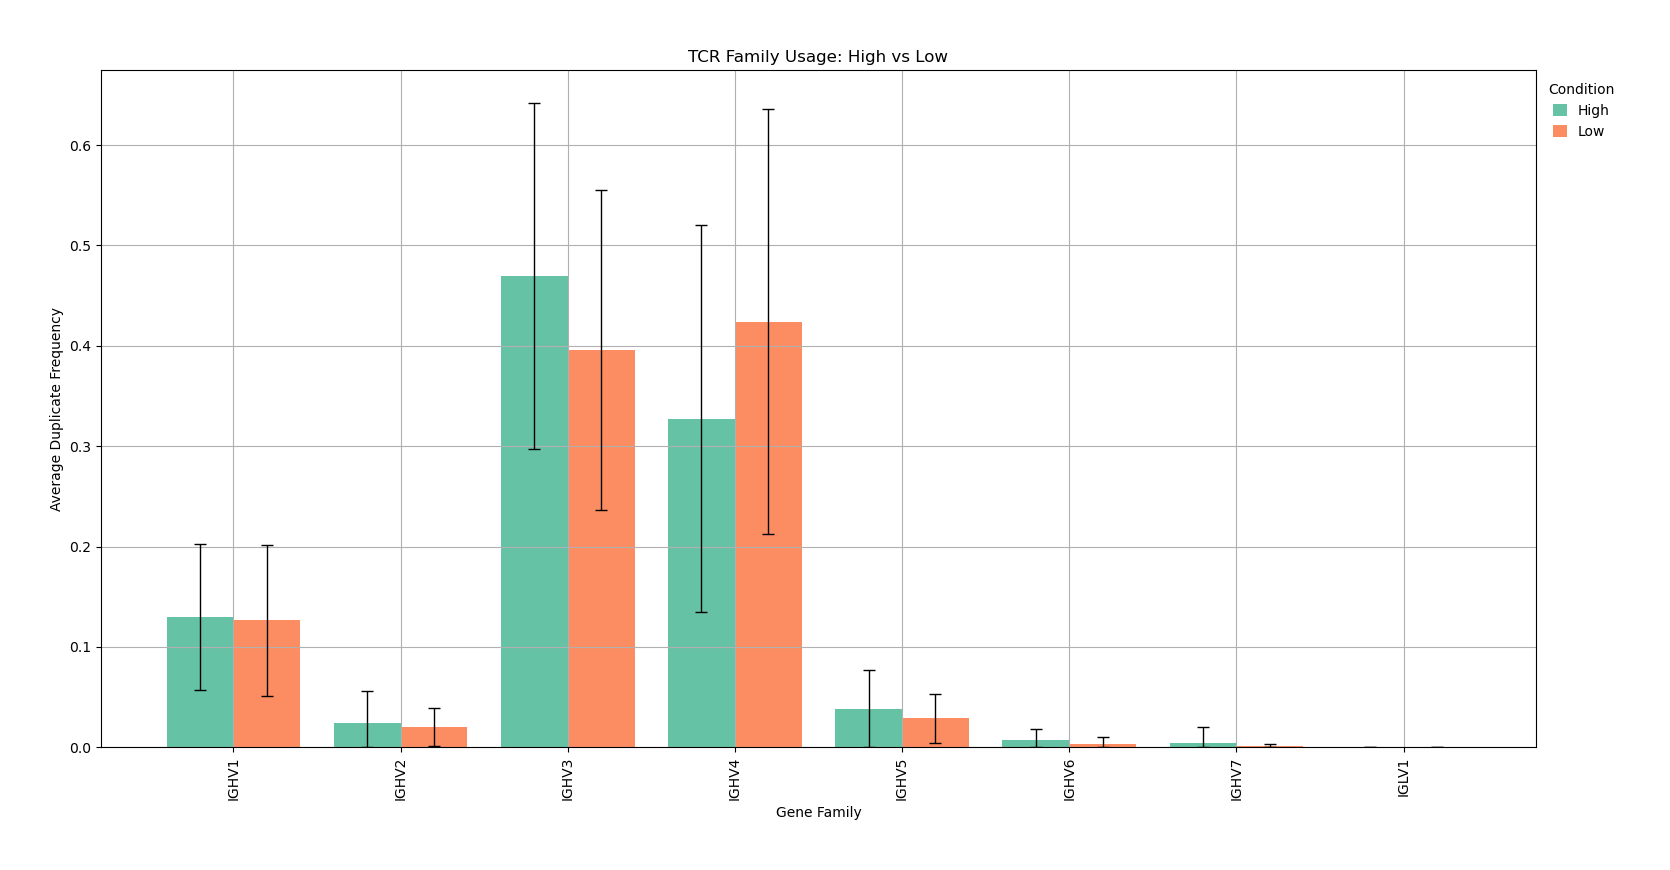

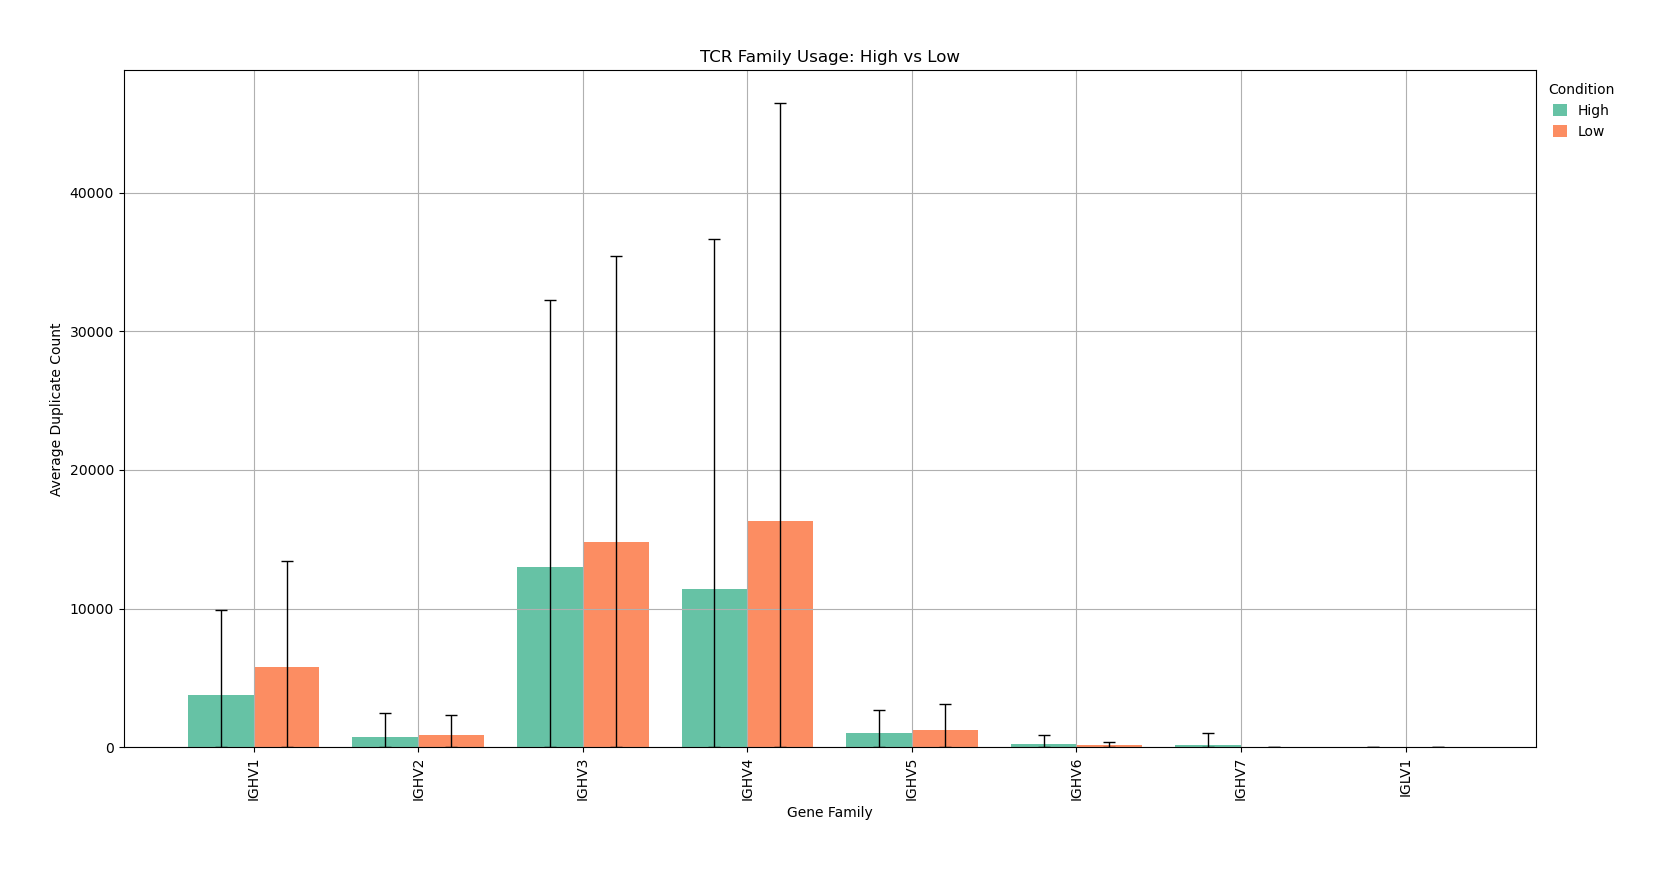

In [5]:
# Step 2: plot
fig, ax = giraffe.plot_gene_usage_groups(gene_usage_df)
fig.show()

fig, ax = giraffe.plot_gene_usage_groups(gene_usage_df, False)
fig.show()


## Load diversity curve data

In [6]:
processing_stage = 'igblast.makedb.gene.clone'
for rep_id in repertoires:
    print(rep_id)
    df = bird.load_diversity_data(repcalc_dir, rep_id, processing_stage)
    print(df)
    break

d3d1d40d-1192-49f2-98b2-cfc7c3064160
                            repertoire_id      q           d      d_sd  \
0    d3d1d40d-1192-49f2-98b2-cfc7c3064160   0.00  233.755000  6.953180   
1    d3d1d40d-1192-49f2-98b2-cfc7c3064160   0.05  203.426040  5.832332   
2    d3d1d40d-1192-49f2-98b2-cfc7c3064160   0.10  176.639260  4.848664   
3    d3d1d40d-1192-49f2-98b2-cfc7c3064160   0.15  153.226477  3.997588   
4    d3d1d40d-1192-49f2-98b2-cfc7c3064160   0.20  132.975196  3.272136   
..                                    ...    ...         ...       ...   
636  d3d1d40d-1192-49f2-98b2-cfc7c3064160  31.80   13.752160  0.212743   
637  d3d1d40d-1192-49f2-98b2-cfc7c3064160  31.85   13.750933  0.212827   
638  d3d1d40d-1192-49f2-98b2-cfc7c3064160  31.90   13.749708  0.212911   
639  d3d1d40d-1192-49f2-98b2-cfc7c3064160  31.95   13.748488  0.212994   
640  d3d1d40d-1192-49f2-98b2-cfc7c3064160  32.00   13.747270  0.213077   

        d_lower     d_upper         e   e_lower   e_upper  
0    220.12701

## Plot diversity curve data

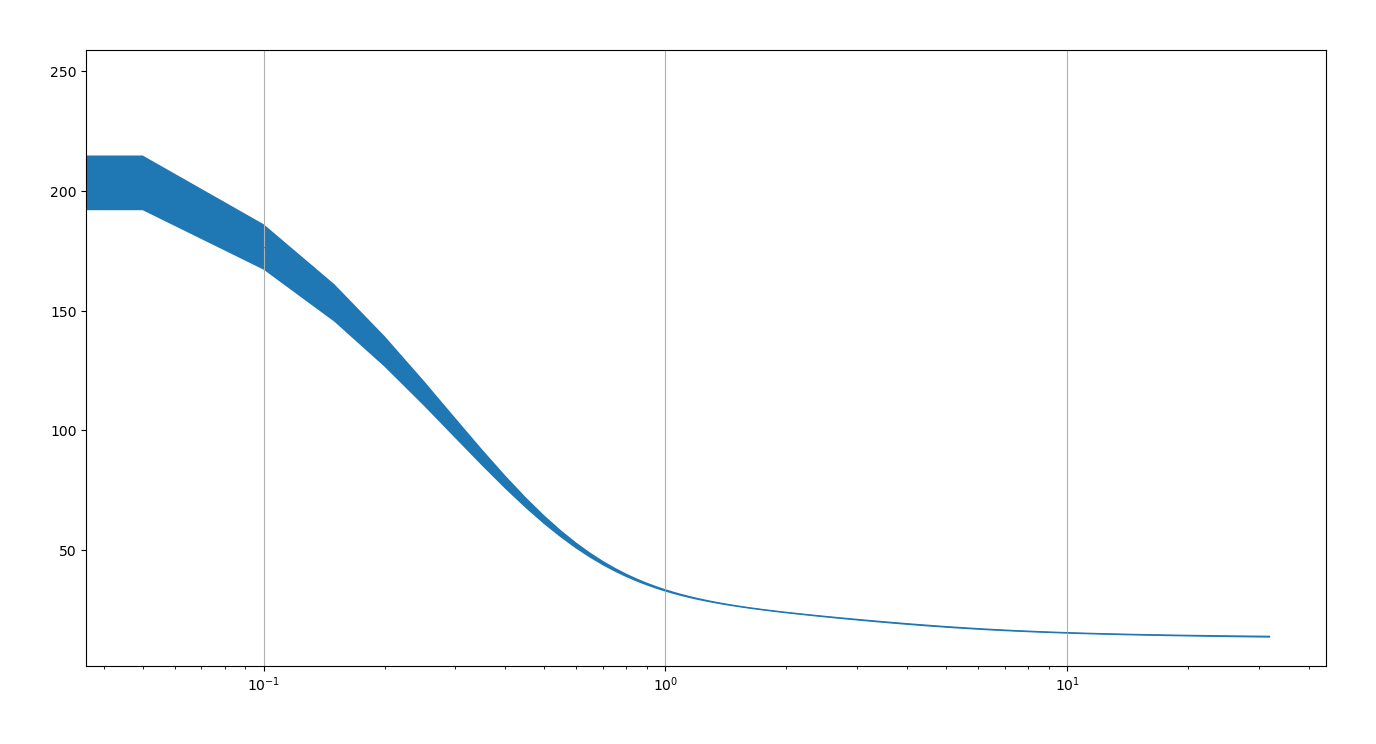

In [7]:
fig, ax = giraffe.plot_diversity_curve(df)
fig.show()